In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = r'C:\Users\toran\Documents\GitHub\ML_PadiCare\data\train'
VALIDATION_DIR = r'C:\Users\toran\Documents\GitHub\ML_PadiCare\data\validation'

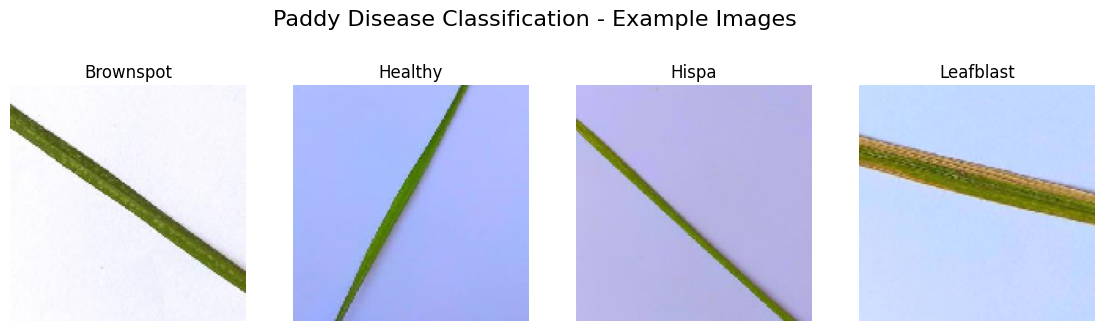

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
fig.suptitle('Paddy Disease Classification - Example Images', fontsize=16)

for idx, disease in enumerate(['brownspot', 'healthy', 'hispa', 'leafblast']):
    disease_dir = os.path.join(TRAIN_DIR, disease)
    img_path = os.path.join(disease_dir, os.listdir(disease_dir)[0])
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    axes[idx].imshow(img)
    axes[idx].set_title(f'{disease.capitalize()}')
    axes[idx].axis('off')

plt.show()

In [4]:
from tensorflow.keras import layers, models
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

def train_val_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=42
    )
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=42
    )
    
    return train_dataset, validation_dataset

training_dataset, validation_dataset = train_val_datasets()


Found 1800 files belonging to 4 classes.
Found 452 files belonging to 4 classes.


In [5]:
training_dataset = training_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

training_dataset = training_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers

def create_custom_cnn():
    # Menggunakan InceptionV3 sebagai model dasar
    base_model = tf.keras.applications.InceptionV3(
        input_shape=(150, 150, 3), 
        include_top=False, 
        weights='imagenet'
    )
    base_model.trainable = False  # Membekukan model dasar

    # Membuat model kustom
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    
    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model  # Mengembalikan model yang dibuat

# Membuat model
model = create_custom_cnn()
print(model.summary())  # Menampilkan ringkasan model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [8]:
# Fine-tune the model by unfreezing some layers of the base model
def fine_tune_model(model):
    base_model = model.layers[0]
    base_model.trainable = True
    fine_tune_at = 100  # Fine-tune from this layer onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

fine_tune_model(model)

In [9]:
def schedule(epoch , lr):
    new_lr = lr * 0.9  # Misalnya, kurangi learning rate 10% setiap epoch
    return float(new_lr)

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)


In [10]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[learning_rate_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 8.999999772640876e-05.
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.4001 - loss: 5.8689 - val_accuracy: 0.3518 - val_loss: 6.1723 - learning_rate: 9.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.100000122794882e-05.
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7662 - loss: 4.9431 - val_accuracy: 0.3319 - val_loss: 5.9720 - learning_rate: 8.1000e-05

Epoch 3: LearningRateScheduler setting learning rate to 7.289999848580919e-05.
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9102 - loss: 4.3749 - val_accuracy: 0.3650 - val_loss: 5.8230 - learning_rate: 7.2900e-05

Epoch 4: LearningRateScheduler setting learning rate to 6.56100019114092e-05.
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9755 - loss: 3.9660 - val_accuracy: 0.3982 - val_loss: 5.8088 - learning_rate: 6.5610e-05

Epoch 5: LearningRateScheduler setting learning rate to 5.90490

In [11]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import models
import numpy as np
import io
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Model dan Class Names
# Asumsikan model sudah dilatih sebelumnya
class_names = {0: 'brownspot', 1: 'healthy', 2: 'hispa', 3: 'leafblast'}  # Map kelas

# File uploader widget
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Output widget
out = widgets.Output()
display(out)

# Ukuran target untuk gambar
IMG_HEIGHT, IMG_WIDTH = 150, 150

# Fungsi untuk memproses dan memprediksi gambar
def file_predict(filename, file_content, out):
    """Memproses dan memprediksi kelas dari gambar yang diunggah."""
    image = Image.open(io.BytesIO(file_content))
    image = image.resize((IMG_HEIGHT, IMG_WIDTH))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Menambahkan batch dimension
    image_array = tf.keras.applications.inception_v3.preprocess_input(image_array)

    predictions = model.predict(image_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]

    with out:
        print(f"{filename} -> Predicted: {predicted_label}")

# Button untuk memproses prediksi
def on_predict_clicked(change):
    """Menangani prediksi ketika tombol diklik."""
    with out:
        out.clear_output()
        if uploader.value:
            for file_info in uploader.value:
                filename = file_info['name']
                file_content = file_info['content']
                file_predict(filename, file_content, out)
        else:
            print("Please upload an image for prediction.")

# Button widget
predict_button = widgets.Button(description="Predict")
predict_button.on_click(on_predict_clicked)
display(predict_button)


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

Button(description='Predict', style=ButtonStyle())